# dsp4bats - extract metrics

Uses the 'dsp4bats' library to extract metrics from bat sound. Metrics are calculate and stored as a dataframe before plotting.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Add path from jupyter to the dsp4bats library.
import sys
path = ".."
sys.path.append(path)

In [3]:
import pathlib
import numpy as np
import pandas as pd
import dsp4bats

In [4]:
# Settings.
high_pass_filter_freq_hz=15000
threshold_dbfs_below_peak = 20.0

In [5]:
# Core functionality.
def read_file_and_extract_metrics():
    
    # Read signal from file. Length 1 sec.
    wave_reader = dsp4bats.WaveFileReader(sound_file_path)
    samp_width = wave_reader.samp_width
    frame_rate = wave_reader.frame_rate
    sampling_freq = wave_reader.sampling_freq
    
    # Create dsp4bats utils.
    signal_util = dsp4bats.SignalUtil(sampling_freq)
    spectrum_util = dsp4bats.DbfsSpectrumUtil(window_size=128,
                                              window_function='kaiser',
                                              kaiser_beta=14,
                                              sampling_freq=sampling_freq)
    # Prepare output file for metrics.
    ##out_file_name = pathlib.Path(sound_file_path).stem + '_Metrics.txt'
    out_file = pathlib.Path(metrics_file_path).open('w')
    out_header = spectrum_util.chirp_metrics_header()
    out_file.write('\t'.join(map(str, out_header)) + '\n')# Read until end of file.
    
    # Read file.
    found_peak_counter = 0
    buffer_number = 0
    # Read buffer, 1 sec.
    signal_1sec = wave_reader.read_buffer()
    
    # Iterate over buffers.
    while len(signal_1sec) > 0:

        # Get noise level for 1 sec.
        noise_level = signal_util.noise_level(signal_1sec)
        noise_level_db = signal_util.noise_level_in_db(signal_1sec)
        print('Noise level: ', np.round(noise_level, 5), '   Noise (db): ', np.round(noise_level_db, 2))

        # Find peaks in time domain.
        peaks = signal_util.find_localmax(signal=signal_1sec,
                                          noise_threshold=noise_level*4.0, # Threshold.
                                          jump=int(sampling_freq/1000), # Jump 1 ms.
                                          frame_length=1024) # Window size.
        for peak_position in peaks:

            # Extract metrics.
            result = spectrum_util.chirp_metrics(
                                        signal=signal_1sec, 
                                        peak_position=peak_position, 
                                        jump_factor=4000, 
                                        high_pass_filter_freq_hz=high_pass_filter_freq_hz, 
                                        threshold_dbfs = noise_level_db, # + 5.0, 
                                        threshold_dbfs_below_peak = threshold_dbfs_below_peak, 
                                        max_frames_to_check=100, 
                                        max_silent_slots=8, 
                                        debug=False)
            if result is False:
                continue # 
            else:
                result_dict = dict(zip(out_header, result))
                ## out_row = [result_dict.get(x, '') for x in out_header]
                # Add buffer steps to peak_signal_index, start_signal_index and end_signal_index.
                out_row = []
                for key in out_header:
                    if '_signal_index' in key:
                        # Adjust index if more than one buffer was read.
                        index = int(result_dict.get(key, 0))
                        index += buffer_number * signal_util.sampling_freq
                        out_row.append(index)
                    else:
                        out_row.append(result_dict.get(key, ''))
                # Write to file.
                out_file.write('\t'.join(map(str, out_row)) + '\n')
                #
                found_peak_counter += 1
        #
        buffer_number += 1
        # Read next buffer.
        signal_1sec = wave_reader.read_buffer()
        
    # Done.
    print('Detected peak counter: ' + str(found_peak_counter))
    wave_reader.close()
    out_file.close()
    #
    return sampling_freq # We need this later...


In [6]:
# Read the produced text file as a dataframe. Calculate and add more columns.
def read_metrics_from_file():
    
    # Read dataframe.
    peak_df = pd.read_csv(metrics_file_path, sep="\t")
    peak_df.tail()
    # Plot time instead of index.
    peak_df['time_peak_s'] = peak_df.peak_signal_index / sampling_freq
    peak_df['time_start_s'] = peak_df.start_signal_index / sampling_freq
    peak_df['time_end_s'] = peak_df.end_signal_index / sampling_freq
    # Calculate intervals between chirps.
    peak_df['interval_s'] = peak_df.time_peak_s.diff()
    peak_df.loc[(peak_df.interval_s > 0.2)] = np.NaN # Too long interval.

    return peak_df

In [7]:
# Plot two diagrams to visualise metrics.
def plot_diagrams():
    fig, (ax1, ax2) = plt.subplots(2,1,
                            figsize=(16, 10), 
                            dpi=150,
                            sharex=True)
    # ax1 - peak freq, etc.
    cs1 = ax1.scatter(
                x=peak_df.time_peak_s,
                y=peak_df.peak_freq_khz,
                s=150,
                c=peak_df.peak_dbfs,
                cmap=plt.get_cmap('Reds'),  #'YlOrRd'
                alpha=0.5)
    ax1.vlines(x=peak_df.time_peak_s, 
               #ymin=peak_df.start_freq_khz, 
               #ymax=peak_df.end_freq_khz,
               ymin=peak_df.max_freq_khz, 
               ymax=peak_df.min_freq_khz,
               linewidth=0.5, 
               alpha=0.8
              )
    ax1.hlines(y=peak_df.peak_freq_khz, 
               xmin=peak_df.time_start_s, 
               xmax=peak_df.time_end_s,
               linewidth=0.5, 
               alpha=0.8
              )
    cbar = fig.colorbar(cs1, ax=ax1, label='dBFS')
    ax1.set_ylim((0,120))
    ax1.minorticks_on()
    ax1.grid(which='major', linestyle='-', linewidth='0.5', alpha=0.6)
    ax1.grid(which='minor', linestyle='-', linewidth='0.5', alpha=0.3)
    ax1.tick_params(which='both', top='off', left='off', right='off', bottom='off')
    
    # ax2 - interval.
    cs2 = ax2.scatter(
                 x=peak_df.time_peak_s,
                 y=peak_df.interval_s,
                 s=40,
                 color='blue',
                 label='Interval (s)',
                 alpha=0.5
                )    
    ax2.set_ylim((0,0.2))
    ax2.minorticks_on()
    ax2.grid(which='major', linestyle='-', linewidth='0.5', alpha=0.6)
    ax2.grid(which='minor', linestyle='-', linewidth='0.5', alpha=0.3)
    ax2.tick_params(which='both', top='off', left='off', right='off', bottom='off') 
    
    # ax3 - duration.
    ax3 = ax2.twinx()
    ax3.scatter(
                 x=peak_df.time_peak_s,
                 y=peak_df.duration_ms,
                 s=40,
                 marker='s',
                 color='red',
                 label='Duration (ms)',
                 alpha=0.5
                )
    ax3.set_ylim((0,20.0))
    
    # Legends
    ax2.legend(loc='upper left')
    ax3.legend(loc='upper right')
    
    # Adjust size on second diagram.
    pos = ax1.get_position()
    pos2 = ax2.get_position()
    ax2.set_position([pos.x0,pos2.y0,pos.width,pos2.height])
    ax3.set_position([pos.x0,pos2.y0,pos.width,pos2.height])
    
    # Titles and labels.
    file_name = pathlib.Path(sound_file_path).name
    fig.suptitle('Metrics from: ' + file_name, 
                 fontsize=12, fontweight='bold', ha='right')
    ax1.set_title('Peak and min/max frequencies, amplitude and start/stop time')
    ax1.set_xlabel('Time(s)')
    ax1.set_ylabel('Frequency (kHz)')
    ax2.set_xlabel('Time(s)')
    ax2.set_title('Interval (s) and duration (ms)')
    ax2.set_ylabel('Interval (s)')
    ax3.set_ylabel('Duration (ms)')
    
    # Save and plot.
    fig.savefig(plot_file_path)
    plt.show()

Noise level:  0.03095    Noise (db):  -30.19
Noise level:  0.00109    Noise (db):  -59.25
Detected peak counter: 12


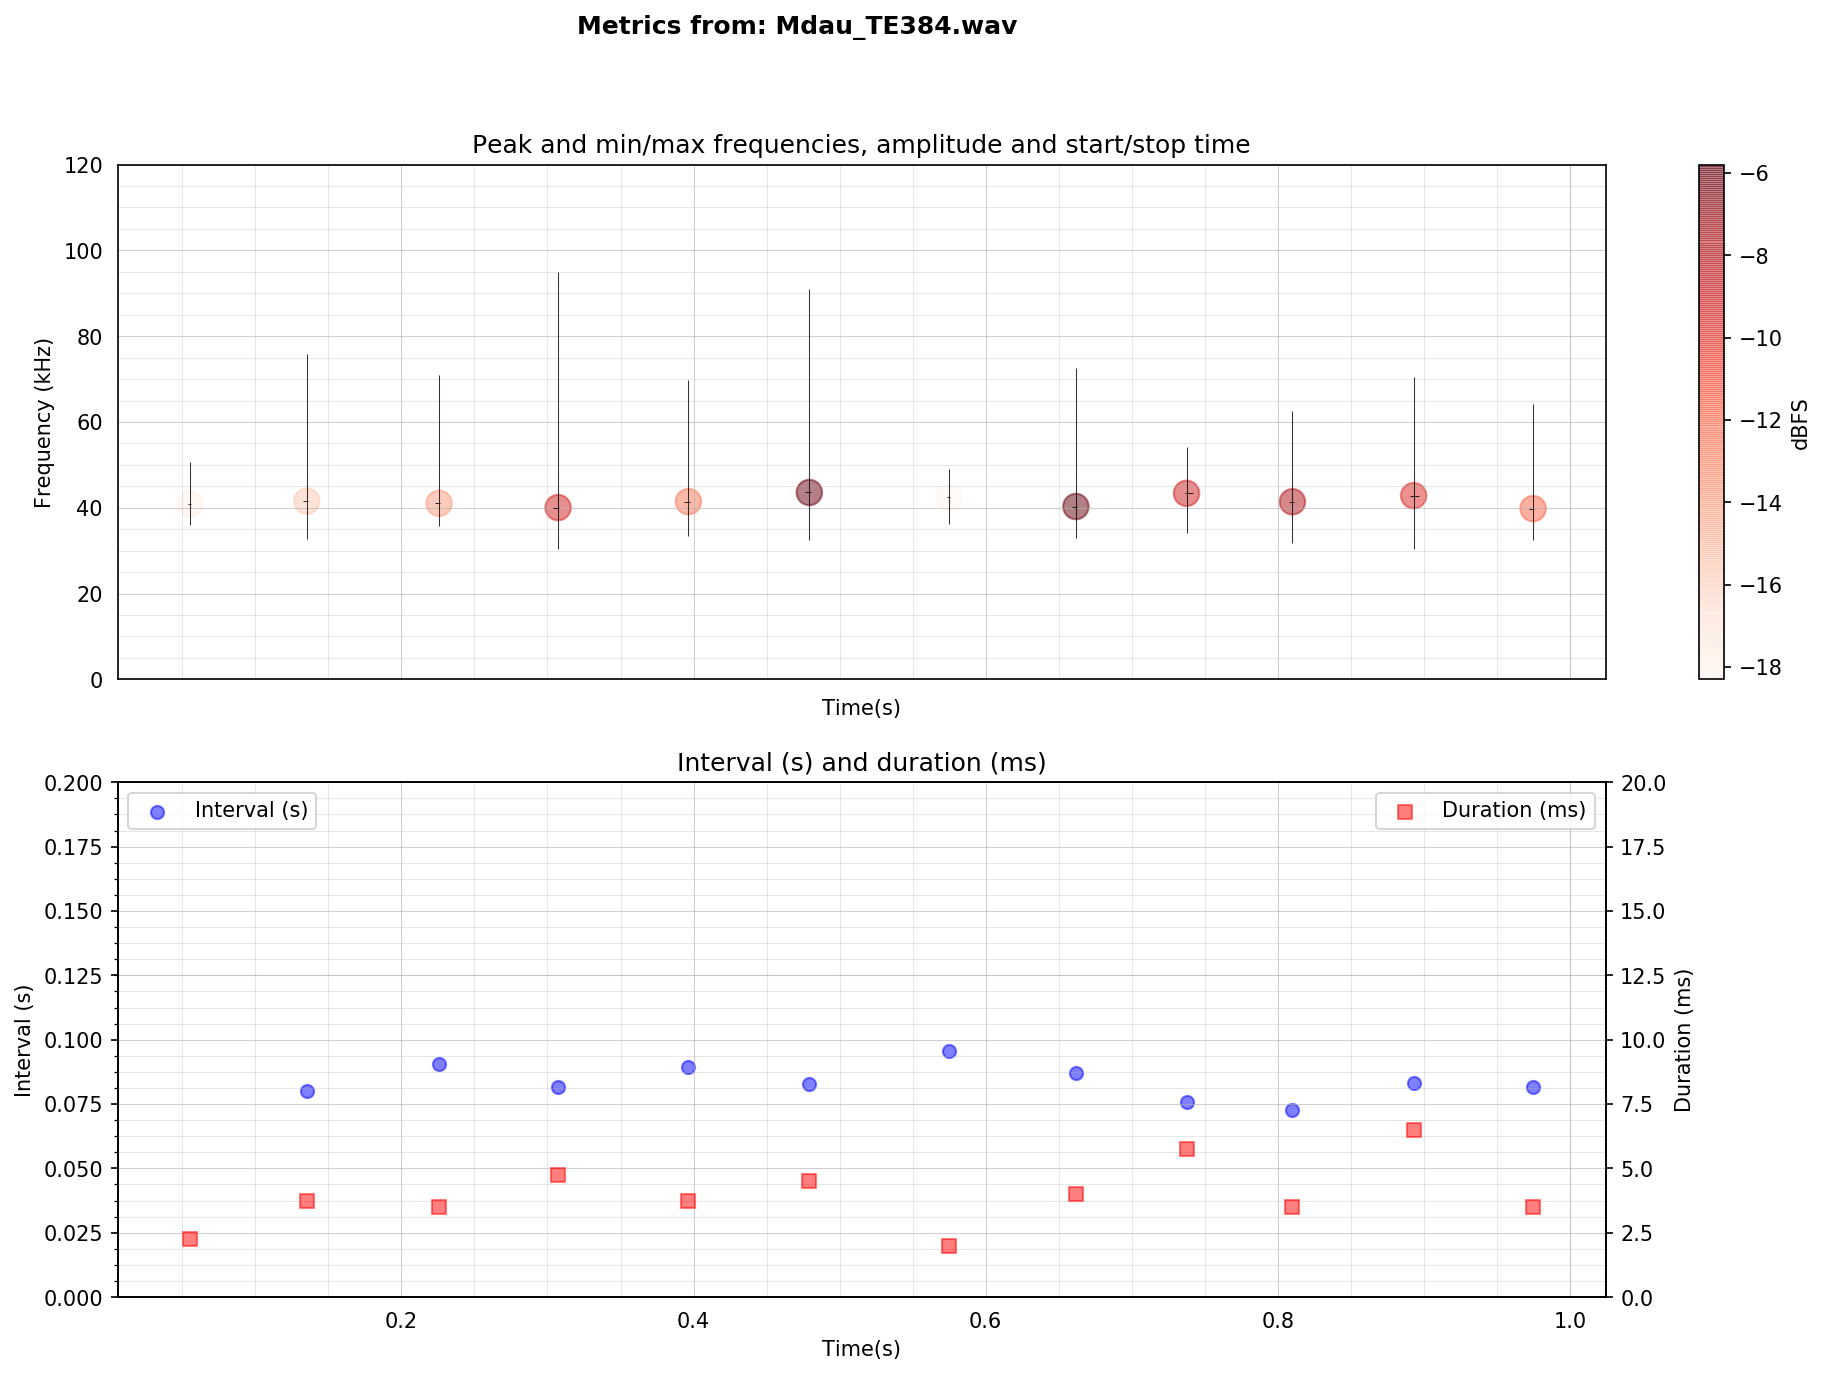

In [8]:
# Calculate and plot metrics for Mdau.

# Settings.
sound_file_path = 'data_in/Mdau_TE384.wav'
metrics_file_path = 'data_out/Mdau_TE384_Metrics.txt'
plot_file_path = 'data_out/Mdau_TE384_Metrics.png'
# Run it.
sampling_freq = read_file_and_extract_metrics()
peak_df = read_metrics_from_file()
plot_diagrams()

In [9]:
# View dataframe for Mdau.
peak_df

,peak_freq_khz,peak_dbfs,start_freq_khz,end_freq_khz,max_freq_khz,min_freq_khz,duration_ms,peak_signal_index,start_signal_index,end_signal_index,time_peak_s,time_start_s,time_end_s,interval_s
0,40.835,-17.9,50.676,36.008,50.676,36.008,2.25,21216.0,20640.0,21408.0,0.05525,0.05375,0.05575,NaN
1,41.550,-15.7,75.756,32.721,75.756,32.721,3.75,51936.0,50880.0,52224.0,0.13525,0.13250,0.13600,0.08000
2,41.035,-13.9,71.033,35.730,71.033,35.730,3.50,86688.0,85632.0,86880.0,0.22575,0.22300,0.22625,0.09050
3,40.042,-9.2,94.866,30.441,94.866,30.441,4.75,117984.0,116544.0,118272.0,0.30725,0.30350,0.30800,0.08150
4,41.433,-12.5,69.794,33.318,69.794,33.318,3.75,152256.0,151200.0,152544.0,0.39650,0.39375,0.39725,0.08925
5,43.561,-5.9,90.977,32.438,90.977,32.438,4.50,184032.0,182784.0,184416.0,0.47925,0.47600,0.48025,0.08275
6,42.416,-18.3,49.046,36.199,49.046,36.199,2.00,220704.0,220320.0,220992.0,0.57475,0.57375,0.57550,0.09550
7,40.290,-5.8,72.588,33.032,72.588,33.032,4.00,254112.0,252960.0,254400.0,0.66175,0.65875,0.66250,0.08700
8,43.360,-9.1,54.171,39.593,54.171,34.099,5.75,283200.0,282720.0,284832.0,0.73750,0.73625,0.74175,0.07575
9,41.401,-7.9,62.508,31.770,62.508,31.770,3.50,311040.0,310176.0,311424.0,0.81000,0.80775,0.81100,0.07250


Noise level:  0.01646    Noise (db):  -35.67
Noise level:  0.01566    Noise (db):  -36.11
Detected peak counter: 12


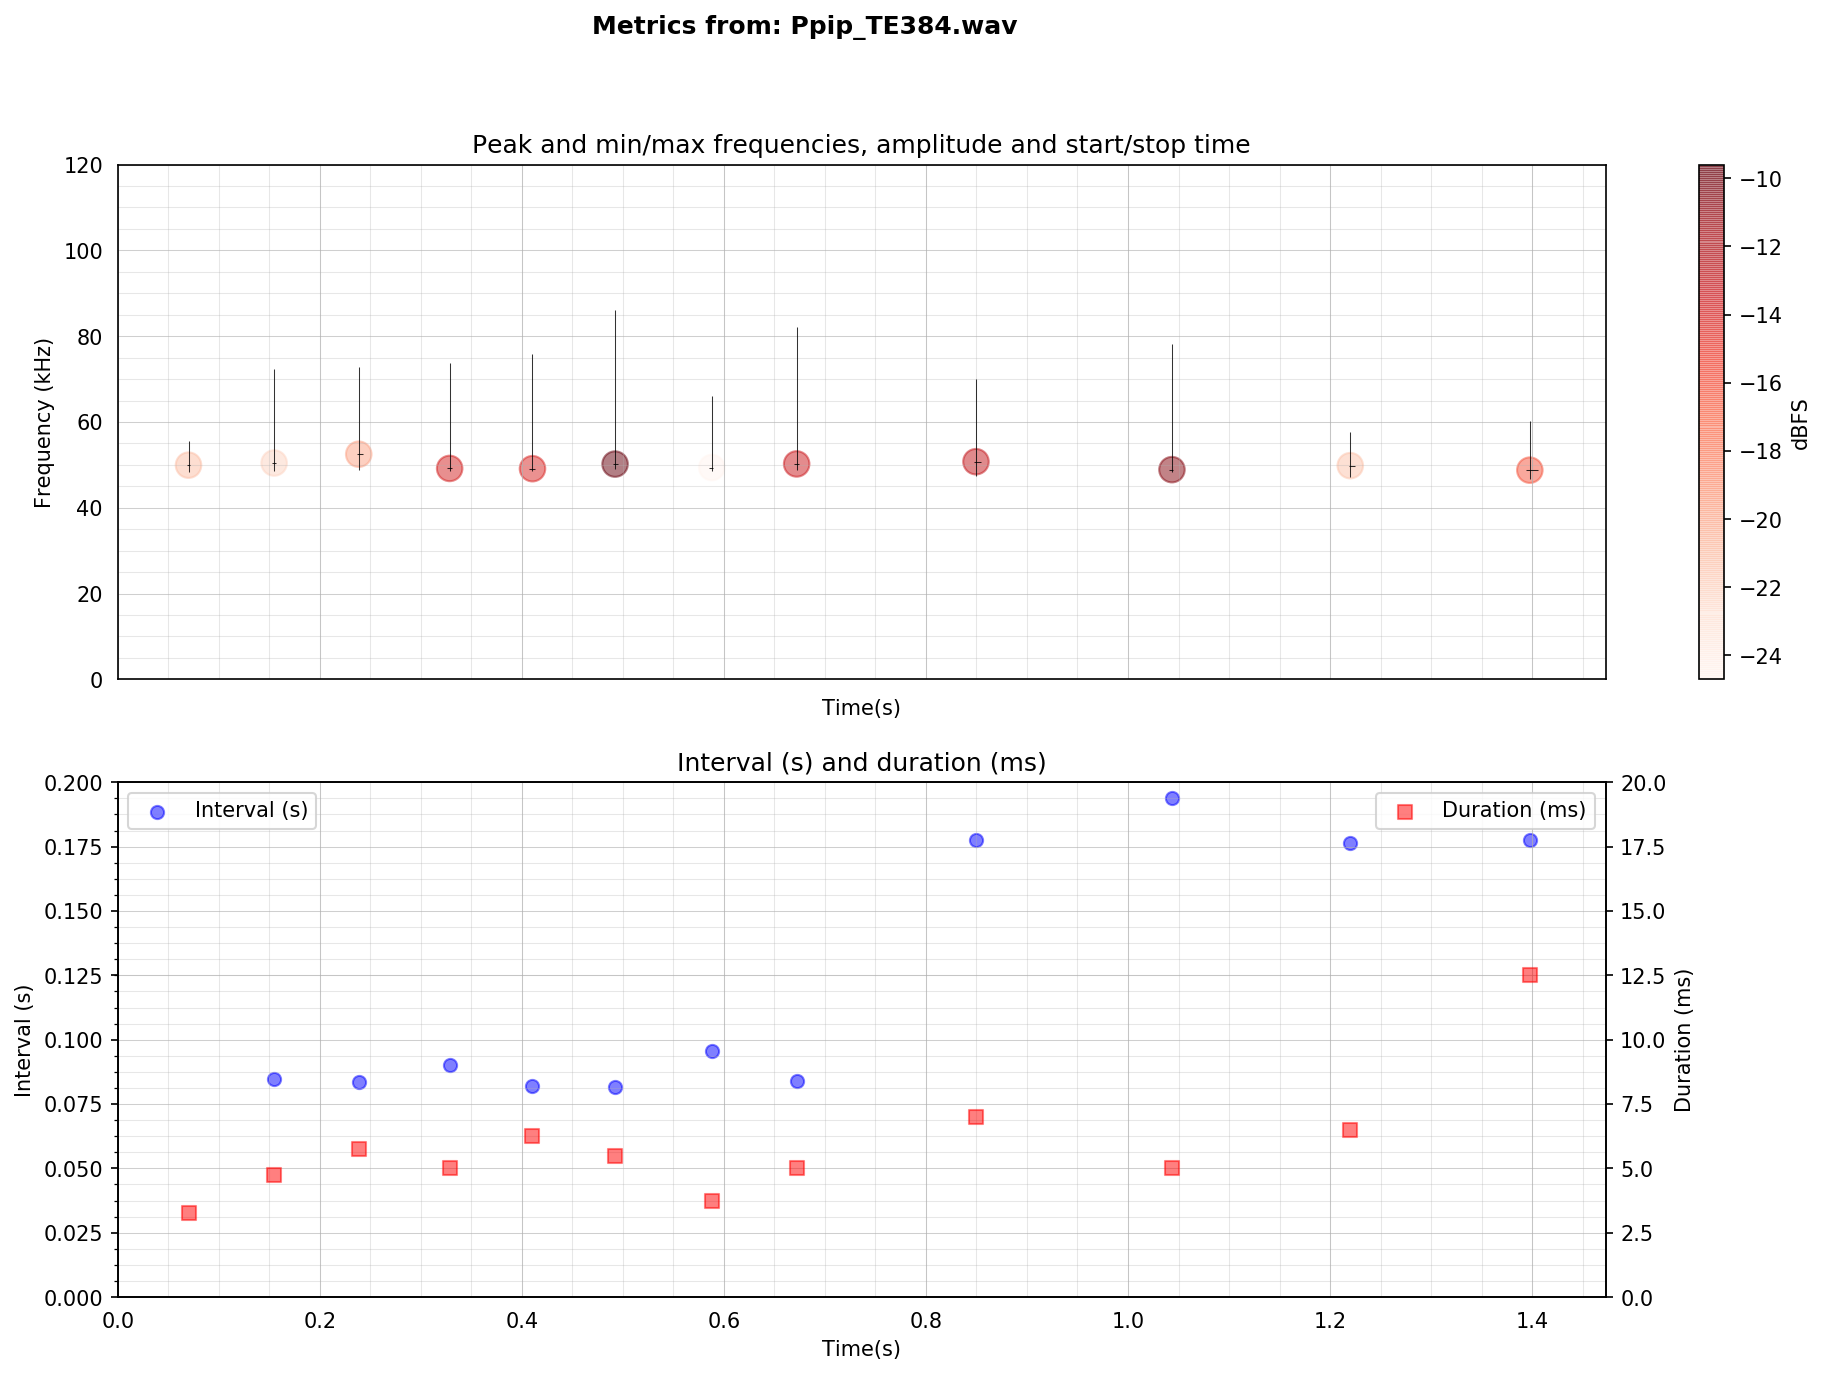

In [10]:
# Calculate and plot metrics for Ppip.

# Settings.
sound_file_path = 'data_in/Ppip_TE384.wav'
metrics_file_path = 'data_out/Ppip_TE384_Metrics.txt'
plot_file_path = 'data_out/Ppip_TE384_Metrics.png'
# Run it.
sampling_freq = read_file_and_extract_metrics()
peak_df = read_metrics_from_file()
plot_diagrams()

In [11]:
# View dataframe for Ppip.
peak_df

,peak_freq_khz,peak_dbfs,start_freq_khz,end_freq_khz,max_freq_khz,min_freq_khz,duration_ms,peak_signal_index,start_signal_index,end_signal_index,time_peak_s,time_start_s,time_end_s,interval_s
0,49.932,-21.1,55.488,48.304,55.488,48.304,3.25,26880.0,26208.0,27360.0,0.07000,0.06825,0.07125,NaN
1,50.433,-22.2,72.413,49.014,72.413,48.590,4.75,59424.0,58560.0,60288.0,0.15475,0.15250,0.15700,0.08475
2,52.484,-19.8,72.823,50.161,72.823,48.757,5.75,91584.0,90912.0,93024.0,0.23850,0.23675,0.24225,0.08375
3,49.169,-13.8,73.833,49.513,73.833,48.660,5.00,126144.0,125088.0,126912.0,0.32850,0.32575,0.33050,0.09000
4,49.111,-14.1,75.929,49.189,75.929,48.534,6.25,157632.0,156384.0,158688.0,0.41050,0.40725,0.41325,0.08200
5,50.184,-9.6,86.167,50.634,86.167,48.947,5.50,189024.0,188064.0,190080.0,0.49225,0.48975,0.49500,0.08175
6,49.377,-24.7,66.050,49.271,66.050,48.539,3.75,225792.0,224832.0,226176.0,0.58800,0.58550,0.58900,0.09575
7,50.219,-13.4,82.063,48.809,82.063,48.809,5.00,258048.0,256992.0,258816.0,0.67200,0.66925,0.67400,0.08400
8,50.739,-13.0,70.099,49.503,70.099,47.414,7.00,326208.0,325536.0,328128.0,0.84950,0.84775,0.85450,0.17750
9,48.888,-10.6,78.123,49.321,78.123,48.339,5.00,400704.0,399456.0,401280.0,1.04350,1.04025,1.04500,0.19400
